# DATA 512 - A1: Data Curation
**Corey Christopherson**
**10/3/2019**  

The purpose of this project was to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1, 2008 through August 30, 2019

In [177]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt

## Data Acquisition

The data for this project was obtained from the Wikipedia Legacy Pagecounts API and Pageviews API

In [18]:
#
### AQUIRE DATA ###
#

In [16]:
# Define data path
path = r'C:/Users/chrico7/Documents/__Corey Christopherson/MS Data Science/Courses/HCDE 512/Week 1/Homework/'

Each endpoint URL was parameterized to support data pulls for the different types of traffic (desktop and mobile). Each API query was initiated using the python requests library and the raw output was immediately stored in a json file

In [9]:
# Define endpoint URLs
endpoint_legacy = ('https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/' +
                   'en.wikipedia.org/{}/monthly/2007010100/2019090100')
endpoint_pageviews = ('https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' + 
                      'en.wikipedia.org/{}/user/monthly/2007010100/2019090100')

# Define API parameter lists
access_site = ['desktop-site','mobile-site']
access = ['desktop','mobile-web','mobile-app']

# Define Git parameters
headers = {'User-Agent': 'https://github.com/yourusername',
           'From': 'youremail@uw.edu'}

In [19]:
# Pull legacy pagecounts data and write raw data to file
#
# desktop-site
pagecounts_desktopsite_request = requests.get(endpoint_legacy.format('desktop-site'))
pagecounts_desktopsite_response = pagecounts_desktopsite_request.json()
with open('{}pagecounts_desktopsite_2007010100-2019090100.json'.format(path),'w') as f:
    json.dump(pagecounts_desktopsite_response,f)
# mobiile-site
pagecounts_mobilesite_request = requests.get(endpoint_legacy.format('mobile-site'))
pagecounts_mobilesite_response = pagecounts_mobilesite_request.json()
with open('{}pagecounts_mobilesite_2007010100-2019090100.json'.format(path),'w') as f:
    json.dump(pagecounts_mobilesite_response,f)

In [20]:
# Pull pageviews data amd write raw data to file
#
# desktop
pageviews_desktop_request = requests.get(endpoint_pageviews.format('desktop'))
pageviews_desktop_response = pageviews_desktop_request.json()
with open('{}pageviews_desktop_2007010100-2019090100.json'.format(path),'w') as f:
    json.dump(pageviews_desktop_response,f)
# mobile-web
pageviews_mobileweb_request = requests.get(endpoint_pageviews.format('mobile-web'))
pageviews_mobileweb_response = pageviews_mobileweb_request.json()
with open('{}pageviews_mobileweb_2007010100-2019090100.json'.format(path),'w') as f:
    json.dump(pageviews_mobileweb_response,f)
# mobile-app
pageviews_mobileapp_request = requests.get(endpoint_pageviews.format('mobile-app'))
pageviews_mobileapp_response = pageviews_mobileapp_request.json()
with open('{}pageviews_mobileapp_2007010100-2019090100.json'.format(path),'w') as f:
    json.dump(pageviews_mobileapp_response,f)

## Data Processing

The data was then processed to support plotting of the desktop, mobile, and combined pageviews.

In [21]:
#
### PROCESS DATA
#

The raw json data was converted into pandas dataframes for easier processing

In [64]:
# Convert json data to pandas dataframes
pagecounts_desktop_raw = pd.io.json.json_normalize(pagecounts_desktopsite_response['items'])
pagecounts_mobile_raw = pd.io.json.json_normalize(pagecounts_mobilesite_response['items'])
pageviews_desktop_raw = pd.io.json.json_normalize(pageviews_desktop_response['items'])
pageviews_mobileweb_raw = pd.io.json.json_normalize(pageviews_mobileweb_response['items'])
pageviews_mobileapp_raw = pd.io.json.json_normalize(pageviews_mobileapp_response['items'])

The timestamp and count columns were extracted from the raw dataframes. To support the merging of the 5 separate frames, the count columns were renamed to identify the original source and the timestamp field was designated as the dataframe index

In [91]:
# Format data frames
pagecounts_desktop = (pagecounts_desktop_raw[['timestamp','count']]
                      .rename({'count':'pagecount_desktop_views'},axis=1).set_index('timestamp'))
pagecounts_mobile = (pagecounts_mobile_raw[['timestamp','count']]
                     .rename({'count':'pagecount_mobile_views'},axis=1).set_index('timestamp'))
pageviews_desktop = (pageviews_desktop_raw[['timestamp','views']]
                     .rename({'views':'pageview_desktop_views'},axis=1).set_index('timestamp'))
pageviews_mobileweb = (pageviews_mobileweb_raw[['timestamp','views']]
                       .rename({'views':'pageview_mobileweb_views'},axis=1).set_index('timestamp'))
pageviews_mobileapp = (pageviews_mobileapp_raw[['timestamp','views']]
                       .rename({'views':'pageview_mobileapp_views'},axis=1).set_index('timestamp'))

The legacy pagecounts frames were combined and a new all_views column (sum of desktop and mobile) was added. NaN values were all filled with 0 to support plotting

In [143]:
# Combine pagecount data into a single frame and add all_views column
pagecounts_all = pd.concat([pagecounts_desktop, pagecounts_mobile],axis=1,sort=False).fillna(0)
pagecounts_all.loc[:,'pagecount_all_views'] = (pagecounts_all['pagecount_desktop_views'] + 
                                               pagecounts_all['pagecount_mobile_views'])

The pageview mobile-app and mobile-web frames were combined into a single frame to encompass all mobile data before being combined with the pageview desktop data. A new all_views columns was added and NaNs filled with 0 as above

In [144]:
# Combine pageview mobile-app and mobile-web into single mobile frame
pageviews_mobile = pd.concat([pageviews_mobileweb, pageviews_mobileapp],axis=1,sort=False).fillna(0)
pageviews_mobile.loc[:,'pageview_mobile_views'] = (pageviews_mobile.loc[:,'pageview_mobileweb_views'] + 
                                                   pageviews_mobile.loc[:,'pageview_mobileapp_views'])
pageviews_mobile = pd.DataFrame(pageviews_mobile['pageview_mobile_views'])

In [145]:
# Combine pageview data into a single frame and add all_views column
pageviews_all = pd.concat([pageviews_desktop, pageviews_mobile],axis=1,sort=False).fillna(0)
pageviews_all.loc[:,'pageview_all_views'] = (pageviews_all['pageview_desktop_views'] + 
                                             pageviews_all['pageview_mobile_views'])

The pagecount and pageview data was then combine into a common frame, NaNs were filled with 0, and the index (timestamp) field was broken out into separate year and month fields. The columns were then placed into the proper order and the numeric index was reset. The final data frame was then written to an output csv

In [146]:
# Combine all data into common frame
all_data = pd.concat([pageviews_all, pagecounts_all],axis=1,sort=False).fillna(0).reset_index()

In [150]:
# Add in year and month fields and drop index field
all_data.loc[:,'year'] = all_data['index'].str[:4]
all_data.loc[:,'month'] = all_data['index'].str[4:6]
all_data.drop('index',axis=1,inplace=True)

In [151]:
# Clean up data frame
all_data = all_data[['index','year','month',
                     'pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
                     'pageview_all_views','pageview_desktop_views','pageview_mobile_views']].sort_values(['year',
                                                                                                          'month'])
all_data = all_data.reset_index(drop=True)

In [160]:
# Write to a csv
all_data.to_csv(r'{}en-wikipedia_traffic_200712-201809.csv'.format(path),header=True,index=False)

## Data Analysis

The data was then further simplified by combining the pagecount and pageview data into a single field for mobile and desktop data. This allows us to plot the legacy and current datasets on a common axis

In [63]:
#
### ANALYZE DATA
#

In [174]:
# Combine mobile, desktop, and all (mobile + desktop) for display
#
# Copy all_data into a new frame
all_data_trim = all_data.copy()

# Combine mobile and desktop traffic. Where duplicate records exist take the pageview (newer) records
all_data_trim.loc[:,'mobile site'] = np.where((all_data_trim['pagecount_mobile_views']!=0)&
                                             (all_data_trim['pageview_mobile_views']!=0),
                                             all_data_trim['pageview_mobile_views'],
                                             (all_data_trim['pagecount_mobile_views']+
                                              all_data_trim['pageview_mobile_views']))/1000000
all_data_trim.loc[:,'main site'] = np.where(((all_data_trim['pagecount_desktop_views']!=0)&
                                             (all_data_trim['pageview_desktop_views']!=0)),
                                             all_data_trim['pageview_desktop_views'],
                                             (all_data_trim['pagecount_desktop_views']+
                                              all_data_trim['pageview_desktop_views']))/1000000

# Combine all data into a total field
all_data_trim.loc[:,'total'] = all_data_trim.loc[:,'mobile site'] + all_data_trim.loc[:,'main site']

# Drop unneeded rows
all_data_trim = all_data_trim[['year', 'month', 'mobile site', 'main site', 'total']]

The year and month fields were combined into a common date field and converted into the timestamp data type. The final plot was then generated and output to a png file

In [191]:
# Combine year and month field into single frame
all_data_trim.loc[:,'date'] = all_data_trim['month'].map(str) + '-' + all_data_trim['year'].map(str)
all_data_trim.loc[:,'date'] = pd.to_datetime(all_data_trim['date'],format='%M-%Y').dt.strftime('%M-%Y')

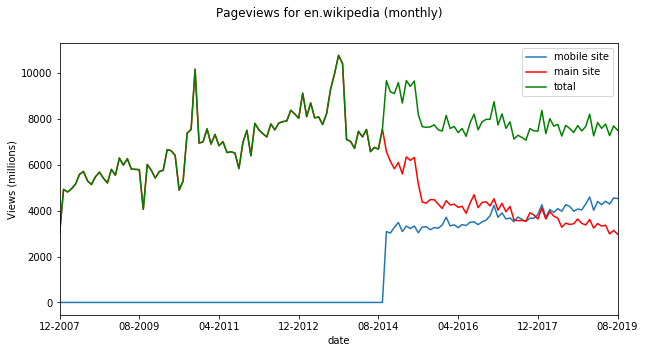

In [203]:
# Plot data
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.suptitle('Pageviews for en.wikipedia (monthly)')
plt.ylabel('Views (millions)')

all_data_trim.plot(kind='line',x='date',y='mobile site',ax=ax)
all_data_trim.plot(kind='line',x='date',y='main site', color='red', ax=ax)
all_data_trim.plot(kind='line',x='date',y='total', color='green', ax=ax)

plt.show()

In [204]:
# Output figure
fig.savefig('{}en-wikipedia_traffic_200712-201809.png'.format(path), dpi=100)